# MC Learning A2C

In [3]:
from project.env_system import ManufacturingSystem
from gymnasium.wrappers import NormalizeReward 
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import erlang

import pandas as pd

import random

# for coping NN
import copy

import warnings
warnings.filterwarnings("ignore")

# Model parameters

In [4]:
#Discount rate of future rewards
GAMMA = 0.99
# Learning rate for NN
LEARNING_RATE = 0.003
# Tot time step per episode
SIM_DURATION= 5000
# Training episodes
TRAINING_EPISODES = 3_000
# training steps
TRAINING_STEPS = TRAINING_EPISODES * SIM_DURATION
# test episodes
TEST_EPISODES = 100
# inter val episode we save the current checkpoint  of the training models
SAVE_CHECKPOINT = 300 * SIM_DURATION
# Save results
RESULTS_NAME = 'MC_based_a2c_4_step'
# path for save the training weights
check_p_path = 'weights/checkpoints/MC_based_a2c_4_step'
# path for save best net weights
best_path = 'weights/best/MC_based_a2c_4_step'
# if we are in a phase of restart the training
RESTART_TRAINGING = False



# SIM PARAMETERS
MAX_WIP= 80
ARRIVAL_TIME = 1/5.1
RANDOM_SEED= 42
EVAL_DAYS= 2500
WARMUP_PERIOD= 114
WIP_TOLERANCE= 7
DAYS_LOOKBACK= 10
N_TRACKERS= 33
SIM_TIME_STEP = 4
MIN_DUE_DATE = 77.00
MAX_DUE_DATE = 110
REWORK= 0.2
VERBOSE= False

#   Actor-Critic Class

In [5]:
class Actor(nn.Module):
    """Actor Network"""
    def __init__(self, observation_space, action_space):
        """ set up the act net"""
        super().__init__()
        self.float()
        # neurons per hidden  layer 
        neurons_per_layer = observation_space
        self.device = 'cpu'
        self.net = nn.Sequential(
            nn.Linear(observation_space, neurons_per_layer).to(self.device),
            nn.ReLU().to(self.device),
            nn.Linear(neurons_per_layer, action_space).to(self.device),
            nn.Softmax(dim=-1)         # Softmax activation to output the action probability
        ).to(self.device)
    
    def act(self, state):
         """Act  and return action and log  prob """
         
         # convert to Tensor
         state = torch.tensor(state, dtype=torch.float32, device=self.device)
         probs = self.net(state)
         
         # Create a categorical distribution over actions
         action_dist = torch.distributions.Categorical(probs)
         # sample the action 
         action = action_dist.sample()

         log_prob = action_dist.log_prob(torch.Tensor(action))


         return action.item(), log_prob
    
    def forward(self, x):
        # Forward pass through the actor net
        x = torch.tensor(x, dtype=torch.float32, device=self.device)
        return self.net(x.to(self.device))

class Critic(nn.Module):
    """Critic Network"""
    def __init__(self, observation_space):
        """ set up the act net"""
        super().__init__()
        self.float()
        # neurons per hidden  layer 
        neurons_per_layer = observation_space
        self.device = 'cpu'
        self.net = nn.Sequential(
            nn.Linear(observation_space, neurons_per_layer).to(self.device),  
            nn.ReLU().to(self.device),                  
            nn.Linear(neurons_per_layer, 1).to(self.device)           # Output layer for state value
        ).to(self.device)
    
    def forward(self, x):
        # Forward pass through the critic net

        # convert to Tensor
        x = torch.tensor(x, dtype=torch.float32, device=self.device)
        return self.net(x)

#  Compute returns Function

In [6]:
def compute_returns(rewards):
    """Compute discounted returns after an episode"""
    R = 0
    returns = []
    for r in reversed(rewards):
        R = r + GAMMA * R  # Calculate discounted return
        returns.insert(0, R)  # Insert at the beginning of the list
    return returns

#   Policy Net training function

In [7]:
def optimize(returns, states_values, actor_net, critic_net, log_probs):
    """Optimization step for Actor and Critic Net"""
    
    # pre processing task
    returns = torch.Tensor(returns)
    state_values = torch.cat(states_values).squeeze(-1)
    log_probs = torch.Tensor(log_probs)
    
    # step for compute the Critic loss 
    critic_loss = (returns - state_values).pow(2).mean()
    
    # reset net gradient 
    critic_net.optimizer.zero_grad()
    
    # backpropagation loss
    # step for compute the actor loss
    advantage = (returns.detach() - state_values.detach())
    
    actor_loss = -(log_probs * advantage ).mean()
    
    # reset net gradient
    actor_net.optimizer.zero_grad()
    
    loss = critic_loss + actor_loss
    # backpropagation loss
    loss.backward()
    
    # clamp the gradient in (-1,-1)
    for param in critic_net.parameters():
        param.grad.data.clamp_(-1, 1)
    
        
    
    # update the net parameters
    critic_net.optimizer.step()
    actor_net.optimizer.step()
    
    return loss.detach().item()

#   Results Plotting function

In [8]:
def plot_results(loss, discounted_returns, wip, throughput, ea_ta_ti, mean_states_value, lengths, agent_releases):
    """"Plot and report results at end of learning process"""
    
    
    # plot loss
    fig = plt.figure(figsize=(6,6))
    ax1 = fig.add_subplot(111)
    
    
    lns1 = ax1.plot(loss, label='loss', color='g', linestyle=':')

    
    

    # Set axes
    ax1.set_xlabel('run')
    ax1.set_ylabel('loss')
    plt.title('Loss Distribution')
    filename = 'output/' + RESULTS_NAME +'/' + RESULTS_NAME + '_loss.png'
    plt.savefig(filename, dpi=300)
    plt.show()
    
    # plot WIP
    plt.plot(wip,
             label='WIP', color='r')
    
    plt.xlabel('Episode')
    plt.ylabel('WIP in System')
    plt.title('WIP Distribution')
    filename = 'output/' + RESULTS_NAME +'/' + RESULTS_NAME + '_wip.png'
    plt.savefig(filename, dpi=300)
    plt.show()

    # plot agent releases
    plt.plot(agent_releases,
             label='agent_releases', color='r')

    plt.xlabel('Episode')
    plt.ylabel('Rate of release')
    plt.title('Agent Releases Distribution')
    filename = 'output/' + RESULTS_NAME + '/' + RESULTS_NAME + '_agent_releases.png'
    plt.savefig(filename, dpi=300)
    plt.show()
    
    # chart for throughput
     # Set up chart (ax1 and ax2 share x-axis to combine two plots on one graph) 
    fig = plt.figure(figsize=(6,6))
    ax1 = fig.add_subplot(111)
    

    lns2 = ax1.plot(throughput,
             label='Throughput', color='y')

    # Set axes
    ax1.set_xlabel('run')
    ax1.set_ylabel('Throughput')
    plt.title('Monthly Throughput Distribution')
    filename = 'output/' + RESULTS_NAME +'/' + RESULTS_NAME + '_throughput.png'
    plt.savefig(filename, dpi=300)
    plt.show()
    
    # chart of mean values functions
    plt.plot(mean_states_value)
    plt.xlabel('Episode')
    plt.ylabel('state values')
    plt.title('Mean state values prediction')
    filename = 'output/' + RESULTS_NAME +'/' + RESULTS_NAME + 'mean_states_value.png'
    plt.savefig(filename, dpi=300)
    plt.show()

    # chart of lengths
    plt.plot(lengths)
    plt.xlabel('Episode')
    plt.ylabel('Episode Length')
    plt.title('Episode Length Distribution')
    filename = 'output/' + RESULTS_NAME + '/' + RESULTS_NAME + 'e_length.png'
    plt.savefig(filename, dpi=300)
    plt.show()
    
    # chart of discounted returns
    plt.plot(discounted_returns)
    plt.xlabel('Episode')
    plt.ylabel('Episode Return')
    plt.title('Discounted Mean Return')
    filename = 'output/' + RESULTS_NAME +'/' + RESULTS_NAME + '_returns.png'
    plt.savefig(filename, dpi=300)
    plt.show()
    
    # Create a new figure for plotting the 3d scatter
    fig = plt.figure()
    
    # Extracting x, y, z coordinates from the data
    x = [point[0] for point in ea_ta_ti]
    y = [point[1] for point in ea_ta_ti]
    z = [point[2] for point in ea_ta_ti]


    # Add a 3D subplot
    ax = fig.add_subplot(111, projection='3d')

    # Create a scatter plot in 3D
    ax.scatter(x, y, z)

    # Create a colormap
    gradient = np.linspace(0, 1, len(ea_ta_ti))

    cool = plt.colormaps['cool']

    # Create a scatter plot in 3D with a color gradient
    sc = ax.scatter(x, y, z, c=gradient, cmap=cool)

    # Highlight the first point
    ax.scatter(x[0], y[0], z[0], color='red', s=100, label='First run')
    ax.text(x[0], y[0], z[0], 'First', color='red')

    # Highlight the last point
    ax.scatter(x[-1], y[-1], z[-1], color='green', s=100, label='Last run')
    ax.text(x[-1], y[-1], z[-1], 'Last', color='green')



    # Customize the tick labels
    # Set color gradient legend with only first and last ticks
    cbar = plt.colorbar(sc, ax=ax, ticks=[0, 1], orientation='vertical', pad=0.1)
    cbar.set_label('Runs')
    cbar.ax.set_yticklabels([1, len(ea_ta_ti)])

    # Labeling the axes
    ax.set_xlabel('EA')
    ax.set_ylabel('TA')
    ax.set_zlabel('TI')

    # Set a title for the plot
    ax.set_title('Job dones distribution')
    ax.legend()
    filename = 'output/' + RESULTS_NAME +'/' + RESULTS_NAME + '_scatter.png'
    plt.savefig(filename, dpi=300)
    
    # Show the plot
    plt.show()

#   Main Progam

In [9]:
def MC_a2c_company():
    """Main program loop"""
    ############################################################################
    #                          1 Set up Gym+SimPy environment                  #
    ############################################################################
    sim = ManufacturingSystem(
        inter_arrival_time_distribution=lambda: random.expovariate(lambd=ARRIVAL_TIME), 
        service_time_distribution=lambda x,y: erlang.rvs(5,loc=(x - 5 *(y/5)**(1/2)),scale=(y/5)**(1/2)),
        rework_distribution=lambda: random.random() <= REWORK,
        due_dates_distribution=lambda : random.uniform(a=MIN_DUE_DATE, b=MAX_DUE_DATE),
        warmup_period=WARMUP_PERIOD,
        max_wip=MAX_WIP,
        sim_duration=SIM_DURATION,
        random_seed=RANDOM_SEED,
        eval_days=EVAL_DAYS,
        wip_tol=WIP_TOLERANCE,
        days_lookback=DAYS_LOOKBACK,
        n_trackers=N_TRACKERS,
        verbose=VERBOSE,
        sim_time_step=SIM_TIME_STEP
    )
    
    # normalize the rewards 
    sim = NormalizeReward(sim)
    
    # get number of obs returned for state
    obs_space = sim.observation_size
    
    # number of actions possible ( boolean)
    action_space = sim.action_size
    
    ############################################################################
    #                    2 Set up actor and critic nets                       #
    ############################################################################
    
    # set up and keep best net performance ( the actor net)
    actor_net = Actor(obs_space, action_space)
    critic_net = Critic(obs_space)
    best_net = copy.deepcopy(actor_net)
    
    # Set loss function and optimizer
    actor_net.optimizer = optim.Adam(
        params=actor_net.parameters(), lr=LEARNING_RATE
    )
    critic_net.optimizer = optim.Adam(
        params=critic_net.parameters(), lr=LEARNING_RATE
    )
    
    
    ############################################################################
    #                     4 Set up + start training loop                      #
    ############################################################################
    
    # set up run counter and learning loop
    all_steps = 0
    continue_learning = True
    best_reward = -np.inf
    
    # check if we've to restart the training 
    if RESTART_TRAINGING:
        # load the state dicts and run counter 
        checkpoint = torch.load(check_p_path)
        actor_net.load_state_dict(checkpoint['actor_state_dict'])
        critic_net.load_state_dict(checkpoint['critic_state_dict'])
        best_net.load_state_dict(checkpoint['best_state_dict'])
        actor_net.optimizer.load_state_dict(checkpoint['actor_opt_state_dict'])
        critic_net.optimizer.load_state_dict(checkpoint['critic_opt_state_dict'])
        all_steps = checkpoint['epoch']
    
    # set up list for results
    results_length = []
    results_losses = []
    results_returns = []
    results_mean_states_value = []
    results_mean_wip = []
    results_mean_throughput = []
    results_ea_ta_ti = []
    results_agent_releases = []
    results_psp_length = []

    
    # Continue repeating episodes until target complete
    while continue_learning:
         # play episode

        
        # reset env 
        state = sim.reset()

        
        # reset lists ( we remember the last all steps counter for compute the length of the episode)
        prev_all_steps = all_steps
        all_steps += WARMUP_PERIOD
        tot_reward = 0
        
        rewards = []
        log_probs = []
        state_values = []
         
        # continue loop until episode complete or truncated
        while True:
            # get action to take ( set eval mode to avoid dropout layers)
            actor_net.eval()
            action, log_prob = actor_net.act(state)


            
            # get state value ( set eval mode to avoid dropout layers)
            critic_net.eval()
            state_value = critic_net(state)
            
            # play action ( get S', R, T, TR)
    
            # Act 
            state_next, reward, terminal, truncated, info = sim.step(action)
            
            tot_reward += reward
            
            # update trackers

            all_steps += SIM_TIME_STEP
            rewards.append(reward)
            log_probs.append(log_prob)
            state_values.append(state_value)
            
            # update state 
            state = state_next
            
            # check if end of episode
            if terminal and not truncated:
                # Clear print row content 
                clear_row = '\r' + ' ' * 500 + '\r'
                print(clear_row, end='')
                process = (all_steps / TRAINING_STEPS) * 100
                # we block when we reach the finish
                process = min(100, process)
                print(f'Training Progress: {process:4.1f}%, ', end='')
                length = all_steps - prev_all_steps
                print(f'Episode length: {length}, ', end='')
                avg_wip = np.mean(info['wip in system'])
                print(f'Average Tot WIP: {avg_wip:4.1f}, ', end='')
                throughput = 30 *(info['number of job dones'] / SIM_DURATION)
                print(f'Throughput: {throughput:4.1f}, ', end='')
                last_ea_ta_ti = info['EA_TA_TI'][-1]
                # trasform in np array
                last_ea_ta_ti = np.array(last_ea_ta_ti)
                last_ea_ta_ti = (last_ea_ta_ti /info['number of job dones']) * 100
                print(f'EA: {last_ea_ta_ti[0]:4.1f}%, ', end='')
                print(f'TA: {last_ea_ta_ti[1]:4.1f}%, ', end='')
                print(f'TI: {last_ea_ta_ti[2]:4.1f}%, ', end='')
                jobs_create = info['number of job create']  
                print(f'jobs create: {jobs_create}, ', end='')
                rate_agent_release = info['Agent releases']
                print(f'Rate of agent release: {rate_agent_release:4.1f}%, ', end='')
                psp_length = info['psp_list']
                print(f'PSP Length: {psp_length:4.1f} ', end='')

                # add to  results lists
                results_mean_states_value.append(np.mean(torch.Tensor(state_values).detach().numpy()))
                results_length.append(length)
                results_mean_wip.append(avg_wip)
                results_mean_throughput.append(throughput)
                results_ea_ta_ti.append(last_ea_ta_ti)
                results_agent_releases.append(rate_agent_release)
                results_psp_length.append(psp_length)
                
                
                if tot_reward > best_reward:
                    best_reward = tot_reward
                    # copy weights 
                    best_net.load_state_dict(actor_net.state_dict())
                
                # check for end  of learning 
                if all_steps >= TRAINING_STEPS:
                    continue_learning = False
                
                # end episode loop
                break
            
            # check if truncated episode
            if truncated:
                
                # Clear print row content 
                clear_row = '\r' + ' ' * 500 + '\r'
                print(clear_row, end='')
                process = (all_steps / TRAINING_STEPS) * 100
                # we block when we reach the finish
                process = min(100, process)
                print(f'Training Progress: {process:4.1f}%, ', end='')
                length = all_steps - prev_all_steps
                print(f'Episode length: {length}, ', end='')
                avg_wip = np.mean(info['wip in system'])
                print(f'Average Tot WIP: {avg_wip:4.1f}, ', end='')
                throughput = 30 *(info['number of job dones'] / SIM_DURATION)
                print(f'Throughput: {throughput:4.1f}, ', end='')
                last_ea_ta_ti = info['EA_TA_TI'][-1]
                last_ea_ta_ti = np.array(last_ea_ta_ti)
                last_ea_ta_ti = (last_ea_ta_ti /info['number of job dones']) * 100
                print(f'EA: {last_ea_ta_ti[0]:4.1f}%, ', end='')
                print(f'TA: {last_ea_ta_ti[1]:4.1f}%, ', end='')
                print(f'TI: {last_ea_ta_ti[2]:4.1f}%, ', end='')
                
                jobs_create = info['number of job create']
                print(f'jobs create: {jobs_create}, ', end='')
                rate_agent_release = info['Agent releases']
                print(f'Rate of agent release: {rate_agent_release:4.1f}%, ', end='')
                psp_length = info['psp_list']
                print(f'PSP Length: {psp_length:4.1f} ', end='')
                
                # add to  results lists
                results_mean_states_value.append(np.mean(torch.Tensor(state_values).detach().numpy()))
                results_length.append(length)
                results_mean_wip.append(avg_wip)
                results_mean_throughput.append(throughput)
                results_ea_ta_ti.append(last_ea_ta_ti)
                results_agent_releases.append(rate_agent_release)
                results_psp_length.append(psp_length)

                # check for end  of learning 
                if all_steps >= TRAINING_STEPS:
                    continue_learning = False

                # end episode loop
                break
            
        # compute the returns for each episode
        returns = compute_returns(rewards)
        
        # optimize nets
        e_loss = optimize(returns, state_values, actor_net, critic_net, log_probs)
         
        # save the discounted returns
        results_returns.append(returns[0])
         
         # check if we've to save the model 
        if all_steps % SAVE_CHECKPOINT == 0:
            torch.save({
                'epoch': all_steps,
                'actor_state_dict': actor_net.state_dict(),
                'critic_state_dict': critic_net.state_dict(),
                'best_state_dict': best_net.state_dict(),
                'actor_opt_state_dict': actor_net.optimizer.state_dict(),
                'critic_opt_state_dict': critic_net.optimizer.state_dict(),
            }, check_p_path)

            # and save the result
            run_details = pd.DataFrame()
            run_details['Episode Length'] = results_length
            run_details['loss'] = results_losses
            run_details['Returns'] = results_returns
            run_details['mean wip'] = results_mean_wip
            run_details['monthly mean throughput'] = results_mean_throughput
            run_details['Agent releases'] = results_agent_releases
            run_details['PSP length'] = results_psp_length

            # convert in np array
            ea_ta_ti = np.array(results_ea_ta_ti)
            run_details['EA %'] = ea_ta_ti[:, 0]
            run_details['TA %'] = ea_ta_ti[:, 1]
            run_details['TI %'] = ea_ta_ti[:, 2]


            filename = 'output/' + RESULTS_NAME +'/' + RESULTS_NAME + '_train_result.csv'
            run_details.to_csv(filename, index=True, index_label='run')


        if e_loss is not None:
             results_losses.append(e_loss)
        

    ############################################################################
    #             5 Learning complete - plot and save results                 #
    ############################################################################
    plot_results(results_losses, results_returns, results_mean_wip, results_mean_throughput,results_ea_ta_ti,
                 results_mean_states_value, results_length, results_agent_releases)
    
    # save results 
    run_details = pd.DataFrame()
    run_details['Episode Length'] = results_length
    run_details['loss'] = results_losses
    run_details['Returns'] = results_returns
    run_details['mean wip'] = results_mean_wip
    run_details['monthly mean throughput'] = results_mean_throughput
    run_details['Agent releases'] = results_agent_releases
    run_details['PSP length'] = results_psp_length
    
    # convert in np array
    ea_ta_ti = np.array(results_ea_ta_ti)
    run_details['EA %'] = ea_ta_ti[:, 0]
    run_details['TA %'] = ea_ta_ti[:, 1]
    run_details['TI %'] = ea_ta_ti[:, 2]
    
    
    filename = 'output/' + RESULTS_NAME +'/' + RESULTS_NAME + '_train_result.csv'
    run_details.to_csv(filename, index=True, index_label='run')
    
    # save best net weights 
    torch.save({
        'best_state_dict': best_net.state_dict()
    },best_path)
    
    ############################################################################
    #                             Test best model                              #
    ############################################################################
    
    print()
    print('Test Model')
    print('----------')
    
    best_net.eval()
    
    # set results dict 
    results = dict()
    results['wip'] = []
    results['returns'] = []
    results['monthly throughput'] = []
    results['EA'] = []
    results['TA'] = []
    results['TI'] = []
    results['Agent releases'] = []
    results['PSP length'] = []
    
    
    # Replicate model runs
    for run in range(TEST_EPISODES):
        # reset env 
        state = sim.reset()
        # set returns
        tot_reward = 0
        
        # continue loop until episode complete
        while True:
            # get action to take 
            best_net.eval()
            action,_ = best_net.act(state)
            
            # Act
            state_next, reward, terminal, truncated, info = sim.step(action)
            
            # update state
            state = state_next
            # update state and reward
            tot_reward += reward


            
            if terminal:
                print(f'Run: {run}, ', end='')
                avg_wip = np.mean(info['wip in system'])
                print(f'Average Tot WIP: {avg_wip:4.1f}, ', end='')
                print(f'Tot reward: {tot_reward}, ', end='')
                throughput = 30 *(info['number of job dones'] / SIM_DURATION)
                print(f'Throughput: {throughput:4.1f}, ', end='')
                last_ea_ta_ti = info['EA_TA_TI'][-1]
                last_ea_ta_ti = np.array(last_ea_ta_ti)
                last_ea_ta_ti = (last_ea_ta_ti /info['number of job dones']) * 100
                print(f'EA: {last_ea_ta_ti[0]:4.1f}%, ', end='')
                print(f'TA: {last_ea_ta_ti[1]:4.1f}%, ', end='')
                print(f'TI: {last_ea_ta_ti[2]:4.1f}%,  ', end='')
                rate_agent_release = info['Agent releases']
                print(f'Rate of agent release: {rate_agent_release:4.1f}% ', end='')
                psp_length = info['psp_list']
                print(f'PSP Length: {psp_length:4.1f} ', end='')

                print()
                # add to results 
                results['wip'].append(avg_wip)
                results['returns'].append(tot_reward)
                results['monthly throughput'].append(throughput)
                results['EA'].append(last_ea_ta_ti[0])
                results['TA'].append(last_ea_ta_ti[1])
                results['TI'].append(last_ea_ta_ti[2])
                results['Agent releases'].append(rate_agent_release)
                results['PSP length'].append(psp_length)
                
                # End episode loop
                break
    
    results = pd.DataFrame(results)
    filename = 'output/' + RESULTS_NAME +'/' + RESULTS_NAME + '_test_result.csv'
    results.to_csv(filename, index=True, index_label='run')

    print()
    print(results.describe())
            
    return run_details
    

#    Model Entry Point

Training Progress: 100.0%, Episode length: 2502, Average Tot WIP:  1.6, Throughput:  0.3, EA: 77.1%, TA: 22.9%, TI:  0.0%, jobs create: 484, Rate of agent release:  2.8%, PSP Length: 436.0                                                                                                                                                                                                                                                                                                                        

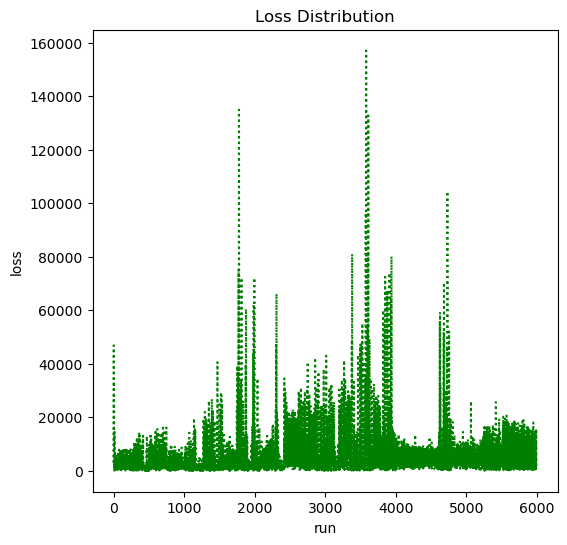

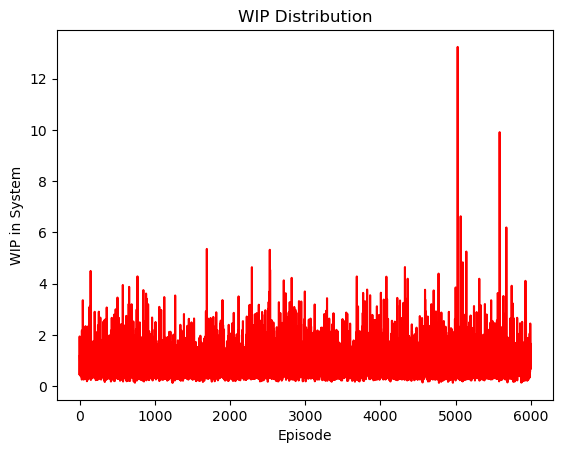

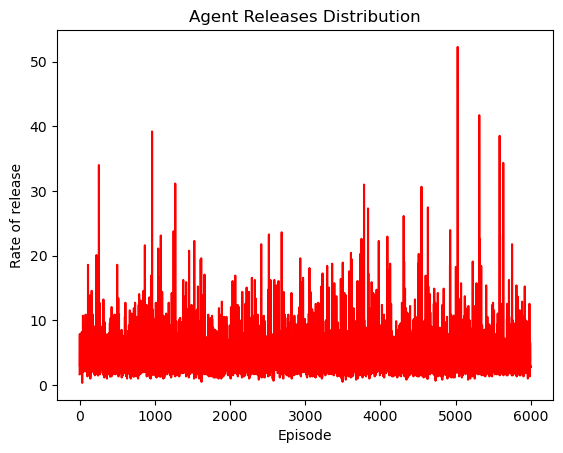

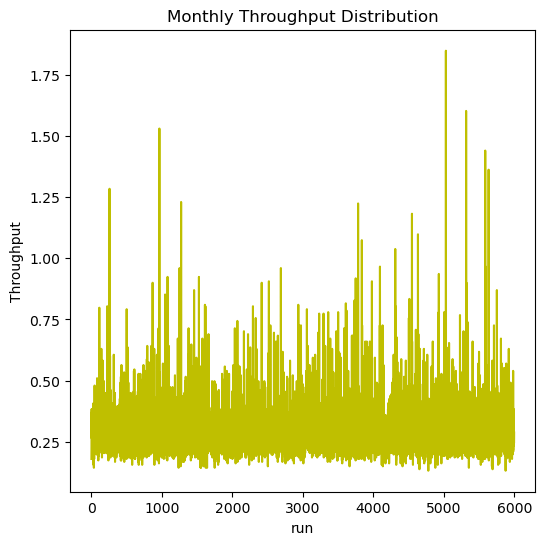

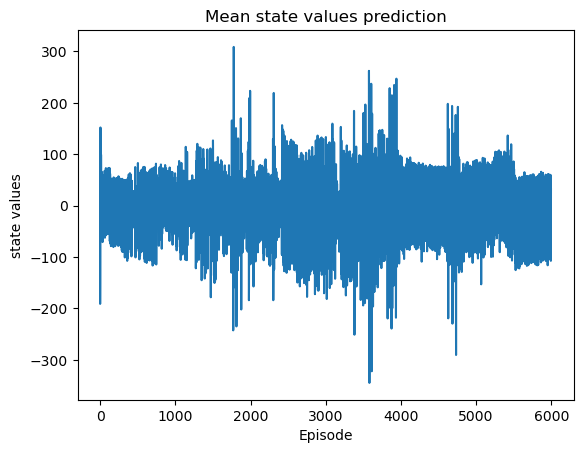

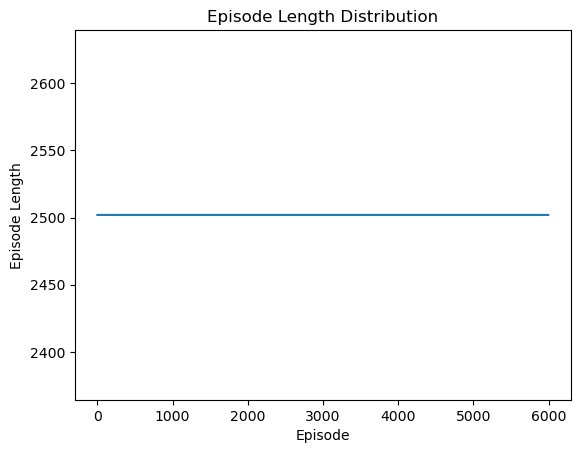

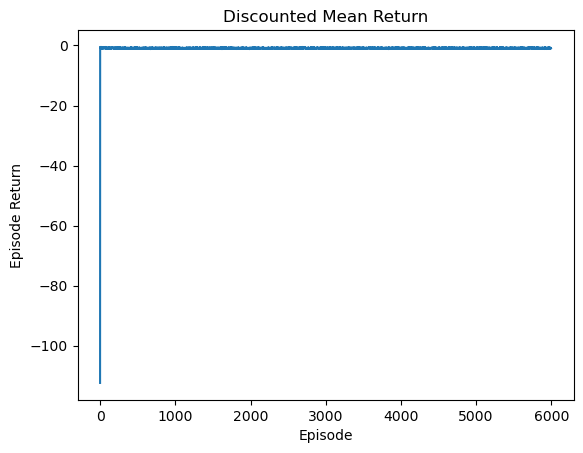

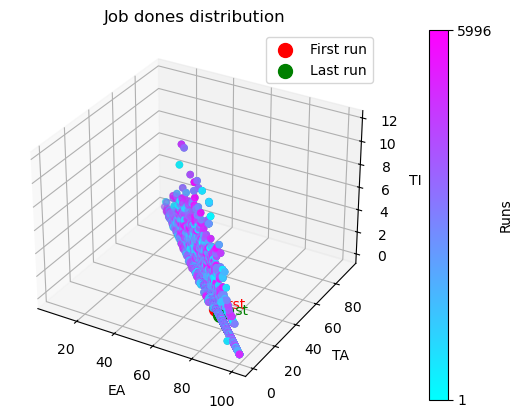


Test Model
----------
Run: 0, Average Tot WIP:  0.2, Tot reward: -116.66952607604064, Throughput:  0.3, EA: 60.4%, TA: 39.6%, TI:  0.0%,  Rate of agent release:  2.1% PSP Length: 924.0 
Run: 1, Average Tot WIP:  0.3, Tot reward: -117.38944924183701, Throughput:  0.2, EA: 89.5%, TA: 10.5%, TI:  0.0%,  Rate of agent release:  1.2% PSP Length: 983.0 
Run: 2, Average Tot WIP:  0.4, Tot reward: -112.34484150268061, Throughput:  0.6, EA: 23.7%, TA: 76.3%, TI:  0.0%,  Rate of agent release:  6.4% PSP Length: 845.0 
Run: 3, Average Tot WIP:  0.3, Tot reward: -113.11251090578493, Throughput:  0.2, EA: 71.4%, TA: 28.6%, TI:  0.0%,  Rate of agent release:  1.2% PSP Length: 948.0 
Run: 4, Average Tot WIP:  1.1, Tot reward: -106.94527328184114, Throughput:  1.6, EA:  9.2%, TA: 90.4%, TI:  0.4%,  Rate of agent release: 20.6% PSP Length: 663.0 
Run: 5, Average Tot WIP:  0.3, Tot reward: -107.7608889077333, Throughput:  0.3, EA: 70.6%, TA: 21.6%, TI:  7.8%,  Rate of agent release:  2.4% PSP Length: 9

Run: 50, Average Tot WIP:  1.3, Tot reward: -70.718788942049, Throughput:  0.3, EA: 69.2%, TA: 30.8%, TI:  0.0%,  Rate of agent release:  1.9% PSP Length: 948.0 
Run: 51, Average Tot WIP:  0.5, Tot reward: -70.06120116837651, Throughput:  0.7, EA: 23.7%, TA: 76.3%, TI:  0.0%,  Rate of agent release:  7.6% PSP Length: 817.0 
Run: 52, Average Tot WIP:  1.8, Tot reward: -70.55045097734055, Throughput:  0.3, EA: 83.3%, TA: 16.7%, TI:  0.0%,  Rate of agent release:  1.0% PSP Length: 917.0 
Run: 53, Average Tot WIP:  0.3, Tot reward: -69.54816425572415, Throughput:  0.3, EA: 51.9%, TA: 46.3%, TI:  1.9%,  Rate of agent release:  2.8% PSP Length: 892.0 
Run: 54, Average Tot WIP:  0.4, Tot reward: -69.12676956899102, Throughput:  0.3, EA: 56.9%, TA: 39.2%, TI:  3.9%,  Rate of agent release:  2.2% PSP Length: 950.0 
Run: 55, Average Tot WIP:  0.3, Tot reward: -68.9974899786521, Throughput:  0.3, EA: 58.0%, TA: 42.0%, TI:  0.0%,  Rate of agent release:  2.3% PSP Length: 956.0 
Run: 56, Average To

In [10]:

if __name__ == '__main__':
    last_run = MC_a2c_company()